In [1]:
import os
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import tf_memory_limit
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model
import keras.backend as K
import keras
import ucscgenome
import pandas
from scipy.special import logit
from scipy.special import expit as sigmoid
import viz_sequence
from sklearn.manifold import TSNE
input_window = 256
batch_size = 32

model_path = '/home/kal/CTCF/mass_CTCF/eric_output/20170731_014309/20170731_014309_weights_3_00_0.90.hdf5'
gen_path='/home/kal/data/ctcfgen_data.hdf5'

bed_path = '/home/kal/data/final_atac.bed'
out_dir = os.path.dirname(model_path)

colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}

genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

Using TensorFlow backend.


In [2]:
# Import the model params.
model = load_model(model_path, custom_objects={'Bias':Bias})
# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)
# load the bed file
peaks = pandas.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf pwm ml'.split()

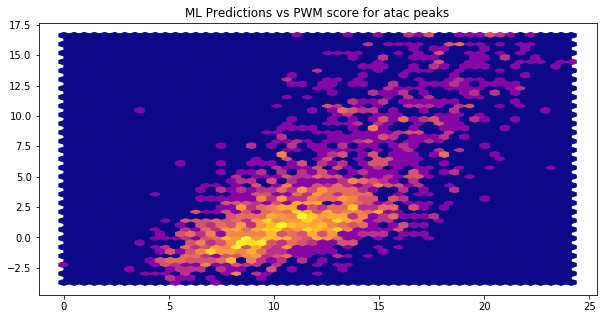

(2000, 6)


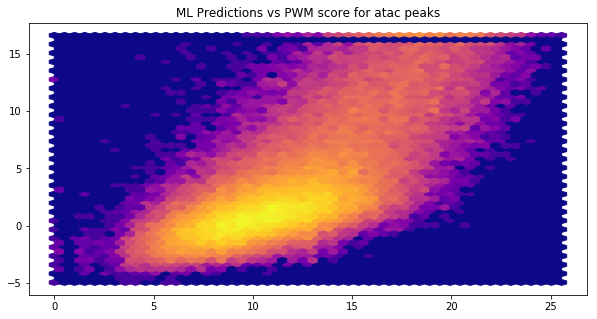

(77257, 6)


In [3]:
smaller = peaks.sample(2000)
# make a plot of the two predictions vs each other
plt.hexbin(smaller['pwm'].tolist(), smaller['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()
print(smaller.shape)

# make a plot of the two precitions vs each other
plt.hexbin(peaks['pwm'].tolist(), peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()
print(peaks.shape)

In [4]:
def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [5]:
def localize(row, verb=False):
    # break the sequence into overlapping tiles
    tile_seqs = list()
    num_tiles = int((row['end']-row['start']) / input_window) + ((row['end']-row['start']) % input_window > 0)
    if verb:
        print(num_tiles)
    for idx in range(num_tiles):
        if row['start'] + idx*input_window - input_window//2 > 0:
            seq = genome[row['chr']][row['start'] + idx*input_window - input_window//2:row['start'] + (idx+1)*input_window - input_window//2].lower()
            tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        else:
            buffered_seq = np.zeros((256,4))
            buffered_seq[:row['start'] + (idx+1)*input_window - input_window//2] = genome[row['chr']][0:row['start'] + (idx+1)*input_window - input_window//2]
            tile_seqs.append(ctcfgen.encode(np.fromstring(buffered_seq).lower(), dtype=np.uint8))
        seq = genome[row['chr']][row['start'] + idx*input_window:row['start'] + (idx+1)*input_window].lower()
        tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        
    tile_seqs= np.asarray(tile_seqs)
    tile_iter = iter(tile_seqs)
    
    # get a batch generator
    batches = ctcfgen.filled_batch(tile_iter, batch_size=batch_size)
    
    # figure out where the max prediction is coming from
    preds = list()
    for batch in batches:
        preds.append(model.predict_on_batch(batch))
    preds = np.asarray(preds).reshape((-1))[:tile_seqs.shape[0]]
    
    # get a tile centered there
    max_idx = np.argmax(preds)
    max_pred = np.max(preds)
    max_tile = batch.reshape((-1, 256, 4))[max_idx]
    if verb:
        print(max_idx)
        print(max_pred)
        print(preds)
    
    return max_tile, max_pred

In [6]:
signal_seqs = list()

for index, row in smaller.iterrows():
    this_seq, max_pred = localize(row)    
    signal_seqs.append(this_seq)

smaller['signal_seq'] = signal_seqs

In [14]:
# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())

# build a function to get nueron activation
layer_name = 'conv1d_3'
seqs = model.input
get_activations = K.function([seqs, K.learning_phase()], [layer_dict[layer_name].output, model.output])

# get the batches for baseline seqs
g = ctcfgen.filled_batch(iter(smaller['signal_seq']), batch_size=32)
base_activations = list()
for input_batch in g:
    activations, predictions = get_activations([input_batch, 0])
    base_activations.append(np.append(activations[:32], activations[32:], axis=1))
    
base_activations = np.asarray(base_activations)
print(base_activations.shape)
base_activations = base_activations.reshape((-1, base_activations.shape[2], base_activations.shape[3]))[:smaller.shape[0]]
max_activations = np.amax(base_activations, axis=1)
print(base_activations.shape)
print(max_activations.shape)
base_activations = base_activations.reshape((base_activations.shape[0], -1))
print(base_activations.shape)

dict_keys(['spatial_dropout1d_2', 'bias', 'spatial_dropout1d_4', 'activation_1', 'spatial_dropout1d_3', 'conv1d_1', 'wide_scan', 'lambda_1', 'stackmax', 'conv1d_4', 'conv1d_2', 'input_1', 'spatial_dropout1d_1', 'final_conv', 'conv1d_3'])
(63, 32, 442, 16)
(2000, 442, 16)
(2000, 16)
(2000, 7072)


(2000, 2)


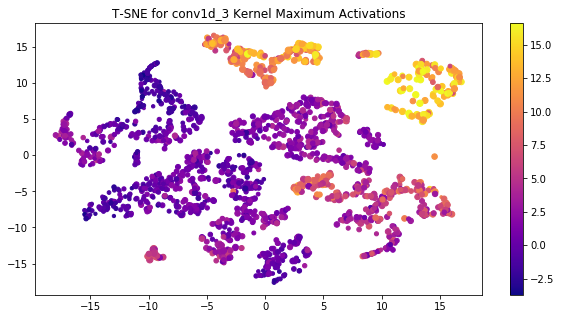

/home/thouis/VENV/lib/python3.5/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


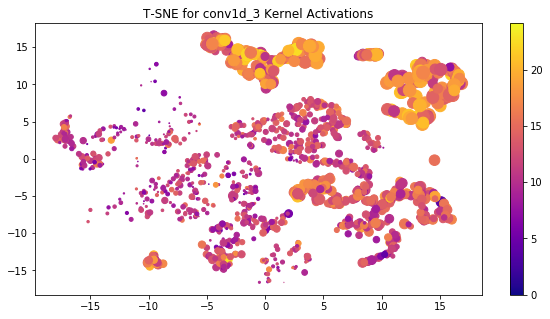

In [16]:
# build a t-sne model
tsnemodel = TSNE(n_components=2, random_state=0)
divisions = tsnemodel.fit_transform(max_activations)
print(divisions.shape)
heatmap = plt.scatter(divisions[:,0], divisions[:,1], c=smaller['ml'], s=smaller['pwm']*2, cmap='plasma')
cbar = plt.colorbar(heatmap)
plt.title('T-SNE for ' + layer_name + ' Kernel Maximum Activations')
plt.show()

heatmap = plt.scatter(divisions[:,0], divisions[:,1], c=smaller['pwm'], s=smaller['ml']*10, cmap='plasma')
cbar = plt.colorbar(heatmap)
plt.title('T-SNE for ' + layer_name + ' Kernel Activations')
plt.show()

(2000, 2)


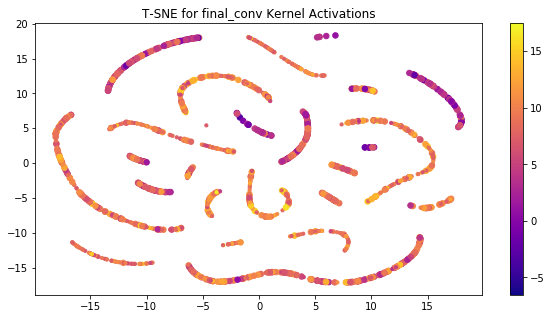

In [12]:
# build a t-sne model
tsnemodel = TSNE(n_components=2, random_state=0)
divisions = tsnemodel.fit_transform(max_activations)
print(divisions.shape)
heatmap = plt.scatter(divisions[:,0], divisions[:,1], c=smaller['pwm'], s=smaller['ctcf']*20+10, cmap='plasma')
cbar = plt.colorbar(heatmap)
plt.title('T-SNE for ' + layer_name + ' Kernel Activations')
plt.show()

In [13]:
def mutagenisis(seq):
    # do a mutant scan
    mutant_window=1

    # get a mutant batch generator
    mutant_gen = ctcfgen.ngram_mutant_gen(seq, n=mutant_window)
    g = ctcfgen.filled_batch(mutant_gen, batch_size=batch_size)
    
    # base importances as large-step gradients
    # score with base there - average of scores without base there
    mutant_preds = list()
    for batch in g:
        mutant_preds.append(model.predict_on_batch(batch))

    return np.asarray(mutant_preds).reshape((-1, 4))  

In [20]:
def get_importance(seq):
    # make sure its a well behaved prediction.
    get_last_output = K.function([model.layers[0].input, K.learning_phase()], 
                                  [model.layers[-1].output])

    score = get_last_output([ctcfgen.blank_batch(seq, batch_size), 0])[0][0][0]
    print('Score: ' + str(score))

    mutant_preds = mutagenisis(seq)
      
    logit_preds = np.asarray(logit(mutant_preds))
    logit_max = logit(score)
    if logit_max == np.inf:
        logit_max = np.nanmax(logit_preds[np.where(np.isfinite(logit_preds))])
        
    diffs = logit_preds - logit_max
    seq_center = np.argmax(np.max(abs(diffs), axis=1), axis=0)
    viz_sequence.plot_weights(seq[seq_center-45:seq_center+45], colors=colors)
    
    all_diffs = list()
    for base_seq, base_preds in zip(seq, logit_preds):
        this_base = list()
        for idx in range(4):
            this_base.append(base_preds[idx] - np.average(base_preds))
        all_diffs.append(list(this_base))

    all_diffs=np.asarray(all_diffs)

    score_diff = list()
    for base_seq, base_preds in zip(seq, logit_preds):
        idx = np.where(base_seq)
        score_diff.append(base_preds[idx] - np.average(base_preds))
      
    score_diff = (seq * score_diff)
    print('Masked average prediciton difference')
    viz_sequence.plot_weights(score_diff[seq_center-45:seq_center+45], colors=colors)

    print('Masked softmax average prediciton difference')
    viz_sequence.plot_icweights(np.multiply(seq, softmax([all_diffs])[0])[seq_center-45:seq_center+45], colors=colors)

    print('Softmax average prediction difference')
    viz_sequence.plot_icweights(softmax([all_diffs])[0][seq_center-45:seq_center+45], colors=colors)

In [21]:
seq = ctcfgen.encode(next(gen.pos_training_gen()))

Score: 0.997512


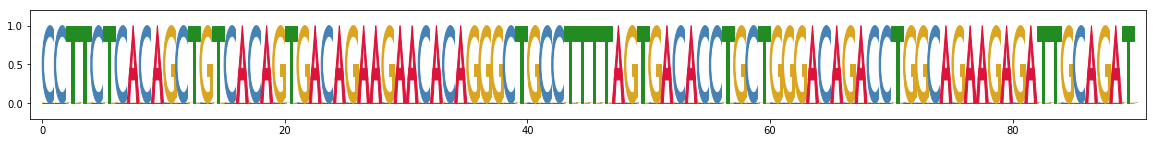

Masked average prediciton difference


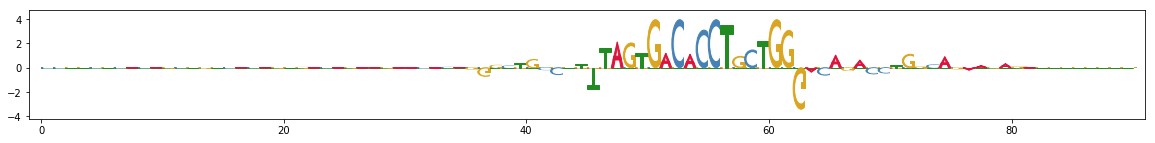

Masked softmax average prediciton difference


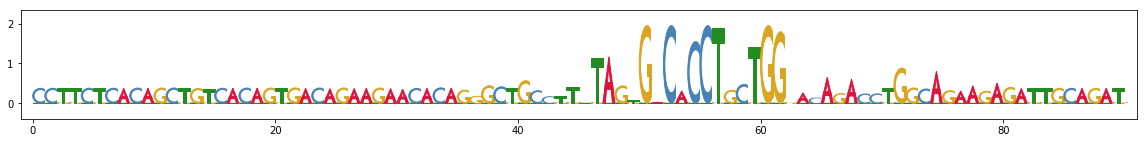

Softmax average prediction difference


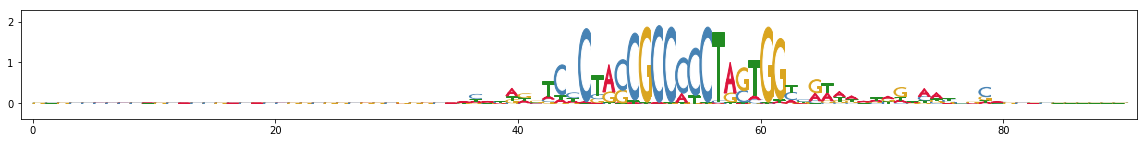

In [22]:
get_importance(seq)